In [2]:
import kagglehub

path = kagglehub.dataset_download("praneet0327/brain-tumor-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-dataset


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
data_dir = pathlib.Path(f"{path}/Brain_Tumor_Dataset")

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

5266


In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 5266 files belonging to 2 classes.
Using 4213 files for training.
Found 5266 files belonging to 2 classes.
Using 1053 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Negative', 'Positive']


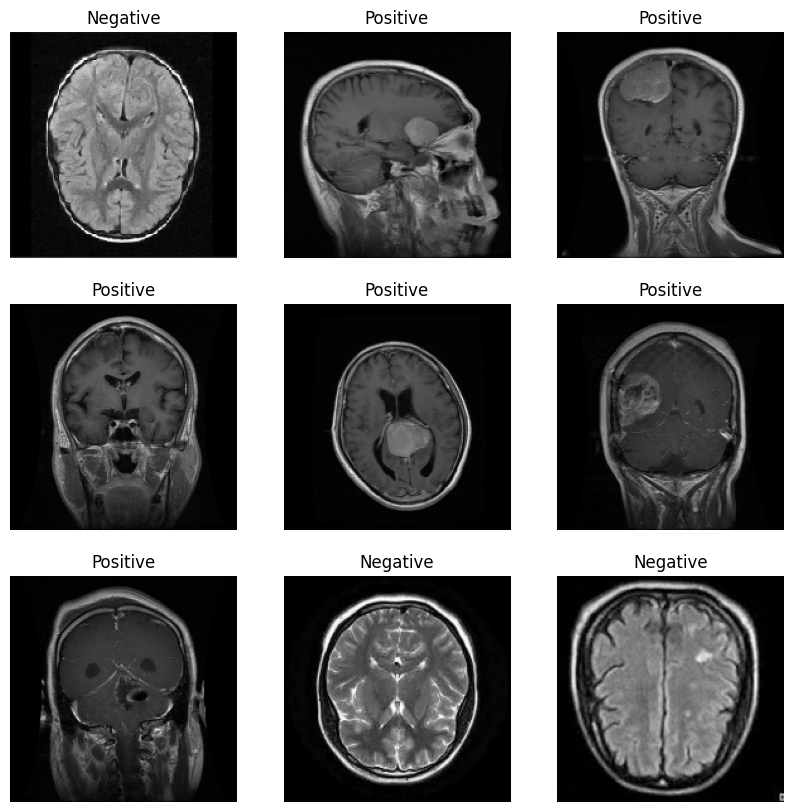

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Input(shape=(img_height, img_width, 3)),
  layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 180, 180, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                     

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, start_from_epoch=10)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
 72/132 [===============>..............] - ETA: 1:07 - loss: 0.4231 - accuracy: 0.8260

KeyboardInterrupt: 

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = len(acc)
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

1/1 [==============================] - 0s 272ms/step


KeyboardInterrupt: 

In [ ]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, last_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.get_layer(last_layer_name).output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
img_path = f"{path}/Brain_Tumor_Dataset/Positive/Te-gl_0030.jpg"

img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)

last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break
last_layer_name = "outputs"

In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, last_layer_name)

img = cv2.imread(img_path)
img = cv2.resize(img, (img_height, img_width))
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(np.uint8(superimposed_img), cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM")
plt.axis('off')
plt.show()

In [ ]:
import os

os.makedirs("gradcam_false_negatives", exist_ok=True)

false_neg_count = 0

for batch, (images, labels) in enumerate(val_ds):
    preds = model.predict(images)

    for i in range(len(images)):
        true_label = labels[i].numpy()
        pred_label = np.argmax(preds[i])

        if true_label == 1 and pred_label == 0:
            false_neg_count += 1

            img_array = tf.expand_dims(images[i], axis=0)

            heatmap = make_gradcam_heatmap(
                img_array,
                model,
                last_conv_layer_name=last_conv_layer_name,
                last_layer_name=last_layer_name,
                pred_index=pred_label
            )

            original_img = np.uint8(images[i].numpy())
            original_img_bgr = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
            overlay = cv2.resize(original_img_bgr, (img_height, img_width))
            heatmap_resized = cv2.resize(heatmap, (img_height, img_width))
            heatmap_rescaled = np.uint8(255 * heatmap_resized)
            heatmap_color = cv2.applyColorMap(heatmap_rescaled, cv2.COLORMAP_JET)
            superimposed_img = heatmap_color * 0.4 + overlay

            combined_img = np.concatenate((original_img_bgr, np.uint8(superimposed_img)), axis=1)

            out_path = f"gradcam_false_negatives/false_negative_{false_neg_count}.jpg"
            cv2.imwrite(out_path, combined_img)

print(f"Saved {false_neg_count} false negative Grad-CAM visualizations.")
print(f"Grad-CAMs for false negatives are saved in: {os.path.abspath('gradcam_false_negatives')}")

References

- TensorFlow’s official image classification tutorial: https://www.tensorflow.org/tutorials/images/classification

- Keras Grad-CAM class activation visualization tutorial: https://keras.io/examples/vision/grad_cam/


In [24]:
model.save("model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
!pip install tensorflow==2.15.0
!pip install tensorflow_decision_forests==1.8.1

In [26]:
!tensorflowjs_converter \
  --input_format=keras \
  model.h5 \
  tfjs_model

2025-06-12 01:41:21.667872: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-12 01:41:21.667925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-12 01:41:21.669308: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-12 01:41:22.667711: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [28]:
!zip -r tfjs_model.zip tfjs_model

updating: tfjs_model/ (stored 0%)
updating: tfjs_model/group1-shard1of4.bin (deflated 7%)
updating: tfjs_model/group1-shard2of4.bin (deflated 7%)
updating: tfjs_model/group1-shard4of4.bin (deflated 7%)
updating: tfjs_model/group1-shard3of4.bin (deflated 7%)
updating: tfjs_model/model.json (deflated 82%)
